In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hdfc-bank/HDFCBANK.NS.csv


In [64]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [65]:
data = pd.read_csv('/kaggle/input/hdfc-bank/HDFCBANK.NS.csv')

data['Date'] = pd.to_datetime(data['Date'])

print(data.isnull().sum())

data = data.dropna()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64


                             Date         Open         High          Low  \
count                        3201  3201.000000  3201.000000  3201.000000   
mean   2017-12-23 14:34:31.602624   896.278007   904.375767   887.584451   
min           2011-06-23 00:00:00   203.000000   206.500000   200.125000   
25%           2014-09-22 00:00:00   430.000000   432.500000   425.700012   
50%           2017-12-22 00:00:00   919.950012   927.450012   910.549988   
75%           2021-03-23 00:00:00  1390.000000  1404.800049  1374.449951   
max           2024-06-21 00:00:00  1723.449951  1757.500000  1713.800049   
std                           NaN   481.027515   485.003066   476.922852   

             Close    Adj Close        Volume  
count  3201.000000  3201.000000  3.201000e+03  
mean    896.141797   857.649367  7.509214e+06  
min     203.000000   183.219757  0.000000e+00  
25%     429.600006   397.398346  3.191069e+06  
50%     919.075012   869.981201  5.299784e+06  
75%    1391.800049  1345.39

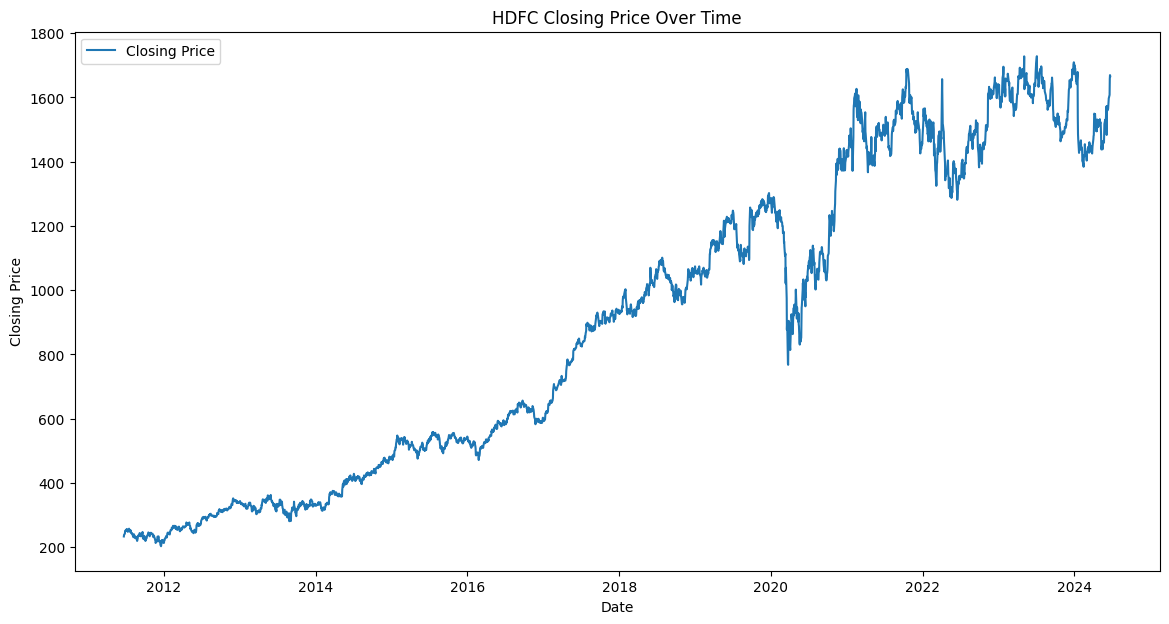

In [66]:
import matplotlib.pyplot as plt

print(data.describe())

plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('HDFC Closing Price Over Time')
plt.legend()
plt.show()

In [67]:
data = data[['Open', 'High', 'Low', 'Close']].sort_index()

print(data.head())

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

print(scaled_df.head())

sequence_length = 10

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-20):
        x = data.iloc[i:i+seq_length].values  # Features: 'Open', 'High', 'Low', 'Close'
        y = data.iloc[i+seq_length+20, 3]  # Label: Close price 20 days ahead
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_df, sequence_length)

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

print(f'Shape of X after reshaping: {X.shape}')

train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

train_split = int(train_ratio * len(X))
validation_split = int((train_ratio + validation_ratio) * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_val, y_val = X[train_split:validation_split], y[train_split:validation_split]
X_test, y_test = X[validation_split:], y[validation_split:]

print(f'Shape of X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape of X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'Shape of X_test: {X_test.shape}, y_test: {y_test.shape}')

         Open        High         Low       Close
0  231.899994  233.945007  231.000000  233.375000
1  234.899994  238.994995  234.154999  238.315002
2  238.300003  243.184998  237.264999  241.615005
3  242.940002  243.000000  240.455002  242.304993
4  243.500000  249.899994  243.500000  248.910004
       Open      High       Low     Close
0  0.019008  0.017695  0.020397  0.019915
1  0.020981  0.020951  0.022482  0.023154
2  0.023217  0.023652  0.024536  0.025318
3  0.026269  0.023533  0.026644  0.025770
4  0.026637  0.027982  0.028655  0.030101
Shape of X: (3171, 10, 4)
Shape of y: (3171,)
Shape of X after reshaping: (3171, 10, 4)
Shape of X_train: (2219, 10, 4), y_train: (2219,)
Shape of X_val: (634, 10, 4), y_val: (634,)
Shape of X_test: (318, 10, 4), y_test: (318,)


In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(100, return_sequences=True)(inputs)
x = Dropout(0.2)(x)

x = LSTM(50)(x)
x = Dropout(0.2)(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])

model.summary()

history = model.fit(X_train, y_train,
                    epochs=200,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,251 (282.23 KB)

 Trainable params: 72,251 (282.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0173 - mae: 0.0710 - val_loss: 0.0074 - val_mae: 0.0728
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0043 - val_mae: 0.0540
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - mae: 0.0364 - val_loss: 0.0054 - val_mae: 0.0606
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - mae: 0.0342 - val_loss: 0.0034 - val_mae: 0.0478
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - mae: 0.0323 - val_loss: 0.0031 - val_mae: 0.0450
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - mae: 0.0333 - val_loss: 0.0046 - val_mae: 0.0555
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - mae: 0.0293 - val_loss: 0.0207 - val_mae: 0.1341
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

In [69]:
X_test_scaled = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f'Test Loss: {loss:.4f}')
print(f'Test MAE: {mae:.4f}')

Test Loss: 0.0159
Test MAE: 0.1156


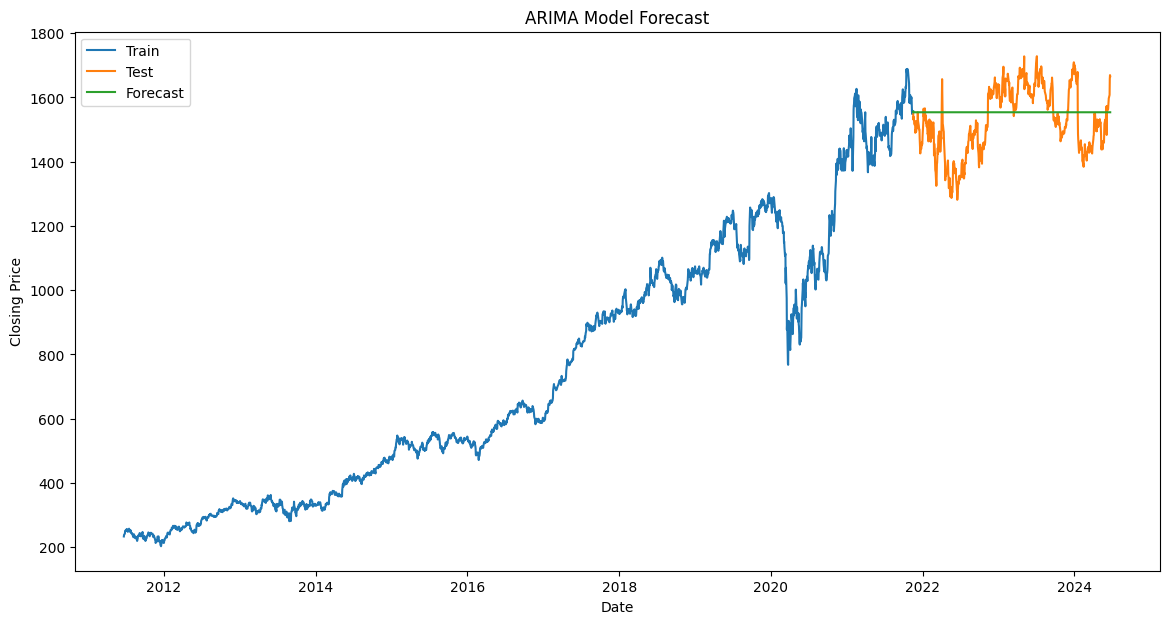

In [25]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

data.set_index('Date', inplace=True)
train, test = train_test_split(data['Close'], test_size=0.2, shuffle=False)

model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 11200.243261145155


In [16]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,MA50,MA200
Date,,,,,,,,
2011-06-23,231.899994,233.945007,231.000000,233.375000,210.635040,4133790.0,NaN,NaN
2011-06-24,234.899994,238.994995,234.154999,238.315002,215.093674,8287730.0,NaN,NaN
2011-06-27,238.300003,243.184998,237.264999,241.615005,218.072144,10256190.0,NaN,NaN
2011-06-28,242.940002,243.000000,240.455002,242.304993,218.694870,6096810.0,NaN,NaN
2011-06-29,243.500000,249.899994,243.500000,248.910004,224.656326,10252440.0,NaN,NaN


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
RandomForestRegressorModel = RandomForestRegressor(n_estimators=100,max_depth=11, random_state=33)
RandomForestRegressorModel.fit(X_train, y_train)

RandomForestRegressorModel.score(X_train, y_train)
RandomForestRegressorModel.score(X_test, y_test)
RandomForestRegressorModel.n_features_

In [ ]:
from sklearn.metrics import  mean_squared_error

In [ ]:
MSEValue = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
print('Mean Squared Error Value is : ', MSEValue)